In [1]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time
import seaborn as sns # Импортируем библиотеку seaborn
sns.set_style('darkgrid') # Устанавливаем стиль графиков

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm -R /content/texts # Проверяем наличие папки texts. Если есть, удаляем ее

In [4]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/MyDrive/machine/base/Тексты писателей.zip' -d /content/texts 

In [5]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [6]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [7]:
sample_text = ['один два три четыре пять два Три три четыре четыре четыре пять пять пять пять шесть семь восемь']
maxWordsCount = 5
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(sample_text)

In [8]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 3.35c


In [10]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

In [11]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
О. Генри    1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
Саймак      1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
----
В сумме  11553605  символов,  1769573  слов 


Статистика по тестовым текстам:
О. Генри    349662 символов,  53238 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
Саймак      318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Брэдберри   868673 символов,  132524 слов
----
В сумме  4395225  символов,  674204  слов


In [12]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [13]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

In [14]:
#Задаём базовые параметры
xLen = 2500 #Длина отрезка текста, по которой анализируем, в словах
step = 245 #Шаг разбиения исходного текста на обучающие векторы

In [15]:
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(7166, 2500)
(7166, 6)
(2694, 2500)
(2694, 6)
Время обработки: 2.5c


In [16]:
cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(7166, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1.]
Время обработки: 12.45c


In [17]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"  
  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [18]:
xTestBoW, xTestEmbedding = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

In [19]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(250, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
56/56 [==============================] - 6s 89ms/step - loss: 0.0705 - accuracy: 0.9795 - val_loss: 0.2882 - val_accuracy: 0.9083
Epoch 2/10
56/56 [==============================] - 5s 82ms/step - loss: 4.5868e-04 - accuracy: 1.0000 - val_loss: 0.2155 - val_accuracy: 0.9414
Epoch 3/10
56/56 [==============================] - 5s 82ms/step - loss: 2.4694e-04 - accuracy: 1.0000 - val_loss: 0.2066 - val_accuracy: 0.9439
Epoch 4/10
56/56 [==============================] - 5s 82ms/step - loss: 1.5339e-04 - accuracy: 1.0000 - val_loss: 0.2092 - val_accuracy: 0.9439
Epoch 5/10
56/56 [==============================] - 5s 86ms/step - loss: 1.2726e-04 - accuracy: 1.0000 - val_loss: 0.2060 - val_accuracy: 0.9443
Epoch 6/10
56/56 [==============================] - 5s 86ms/step - loss: 9.5966e-05 - accuracy: 1.0000 - val_loss: 0.2069 - val_accuracy: 0.9462
Epoch 7/10
56/56 [==============================] - 5s 82ms/step - loss: 8.3016e-05 - accuracy: 1.0000 - val_loss: 0.2057 - val_accura

In [20]:
model01.save('/content/drive/MyDrive/model_writers.h5')

In [21]:


model01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               5000250   
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1506      
Total params: 5,002,756
Trainable params: 5,002,256
Non-trainable params: 500
_________________________________________________________________


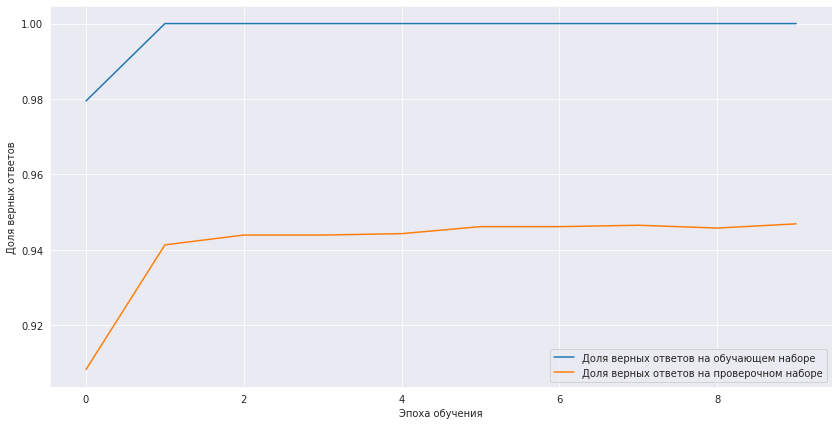

In [22]:

plt.figure(figsize = (14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [23]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTestBoW, "Тексты BoW+sigmoid")

НЕЙРОНКА:  Тексты BoW+sigmoid

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 88% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   99% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     94% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       89% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 94%



In [24]:
model01.compile(optimizer=Adam(0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history1 = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
56/56 [==============================] - 5s 87ms/step - loss: 4.1830e-05 - accuracy: 1.0000 - val_loss: 0.2004 - val_accuracy: 0.9465
Epoch 2/10
56/56 [==============================] - 5s 88ms/step - loss: 3.9943e-05 - accuracy: 1.0000 - val_loss: 0.2000 - val_accuracy: 0.9465
Epoch 3/10
56/56 [==============================] - 5s 83ms/step - loss: 3.2209e-05 - accuracy: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9469
Epoch 4/10
56/56 [==============================] - 5s 85ms/step - loss: 3.0594e-05 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9465
Epoch 5/10
56/56 [==============================] - 5s 86ms/step - loss: 2.6216e-05 - accuracy: 1.0000 - val_loss: 0.1965 - val_accuracy: 0.9469
Epoch 6/10
56/56 [==============================] - 5s 84ms/step - loss: 2.5711e-05 - accuracy: 1.0000 - val_loss: 0.1956 - val_accuracy: 0.9462
Epoch 7/10
56/56 [==============================] - 5s 84ms/step - loss: 2.3891e-05 - accuracy: 1.0000 - val_loss: 0.1931 - val_ac

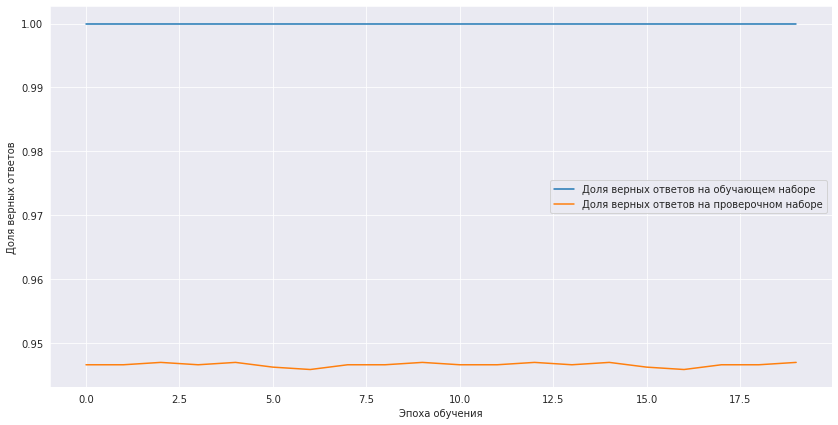

In [25]:
plt.figure(figsize = (14,7))
plt.plot(history1.history['accuracy'] + history1.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'] + history1.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [26]:
model01.compile(optimizer=Adam(0.000001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history1 = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
56/56 [==============================] - 5s 86ms/step - loss: 1.7369e-05 - accuracy: 1.0000 - val_loss: 0.1879 - val_accuracy: 0.9469
Epoch 2/10
56/56 [==============================] - 5s 84ms/step - loss: 1.8338e-05 - accuracy: 1.0000 - val_loss: 0.1880 - val_accuracy: 0.9473
Epoch 3/10
56/56 [==============================] - 5s 84ms/step - loss: 1.7186e-05 - accuracy: 1.0000 - val_loss: 0.1879 - val_accuracy: 0.9473
Epoch 4/10
56/56 [==============================] - 5s 82ms/step - loss: 1.6927e-05 - accuracy: 1.0000 - val_loss: 0.1877 - val_accuracy: 0.9477
Epoch 5/10
56/56 [==============================] - 5s 84ms/step - loss: 1.8825e-05 - accuracy: 1.0000 - val_loss: 0.1872 - val_accuracy: 0.9480
Epoch 6/10
56/56 [==============================] - 5s 83ms/step - loss: 1.8492e-05 - accuracy: 1.0000 - val_loss: 0.1877 - val_accuracy: 0.9477
Epoch 7/10
56/56 [==============================] - 5s 83ms/step - loss: 1.6186e-05 - accuracy: 1.0000 - val_loss: 0.1875 - val_ac